# Dummy Dataset

Developing a RUL estimation approach involves iterating multiple possible solutions as fast as possible. The dummy dataset helps with this by being tiny and simple to fit, so you can quickly test out your approach.

It is fully compatible with the data modules and can be used as a drop-in replacement for each real dataset in this library.

In [21]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

import rul_datasets

logging.getLogger("lightning").setLevel(logging.ERROR)

## The Approach

Below you can see a simple LightningModule that implements supervised training of a RUL estimation network. The network is a single 1D-Conv layer with three fully-connected layers. We train with the Adam optimizer and an MSE loss. The RUL values are scaled between 0 and 1 using the default `max_rul` of the dummy dataset.

The validation and test metric is the RMSE. Test metrics are calculated for both sub-datasets of the dummy dataset to check how well the approach generalizes.

In [22]:
class Supervised(pl.LightningModule):
    def __init__(self):
        super(Supervised, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 8, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.ReLU(),
        )
        self.regressor = nn.Sequential(nn.Linear(2, 1))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.05)

    def forward(self, features):
        return self.regressor(self.feature_extractor(features))

    def training_step(self, batch, batch_idx):
        features, labels = batch
        preds = self.forward(features)
        loss = nn.functional.mse_loss(preds / 50, labels / 50)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx = None):
        features, labels= batch
        preds = self.forward(features)
        loss = nn.functional.mse_loss(preds, labels)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx, dataloader_idx = None):
        features, labels= batch
        preds = self.forward(features)
        loss = nn.functional.mse_loss(preds, labels)
        self.log(f"test_loss_fd{dataloader_idx+1}", loss)


## The Training Loop

This training loop constructs a BaselineDataModule using the FD1 sub-dataset of the dummy dataset. The data module uses the `dev` split of FD1 for training, the `val` split of FD1 for validation, and the `test` split of both FD1 and FD2 for testing.

The training is run for 50 epochs and the test metrics are calculated using the most recent network parameters. To test how stable the training is, it is repeated `num_replication` times. This takes about 2 minutes on a fairly recent laptop CPU.

In [23]:
def train(num_replications):
    fd1 = rul_datasets.reader.DummyReader(1)
    dm = rul_datasets.BaselineDataModule(rul_datasets.RulDataModule(fd1, batch_size=16))

    results = []
    for _ in tqdm(range(num_replications)):
        lm = Supervised()
        trainer = pl.Trainer(max_epochs=50, enable_progress_bar=False, enable_model_summary=False)
        trainer.fit(lm, dm)
        results.append(trainer.test(lm, dm))

    return results

In [ ]:
test_results = train(10)

In [25]:
# re-ordering the results into numpy arrays
fd1_results = np.empty(len(test_results))
fd2_results = np.empty_like(fd1_results)
for i, (fd1_res, fd2_res) in enumerate(test_results):
    fd1_results[i] = fd1_res["test_loss_fd1/dataloader_idx_0"]
    fd2_results[i] = fd2_res["test_loss_fd2/dataloader_idx_1"]

## The Results

In the box plot below you can see how our approach performs. It can fit FD1 pretty reasonably. Unfortunately, it does not generalize well, as the performance on FD2 is much worse.

A second thing to notice are the outliers (blue and orange dots). These indicate that our approach is not stable as test performance varies wildly between training runs. It even seems like is doesn't learn anything sometimes. We are now able test out different solutions to improve stability.

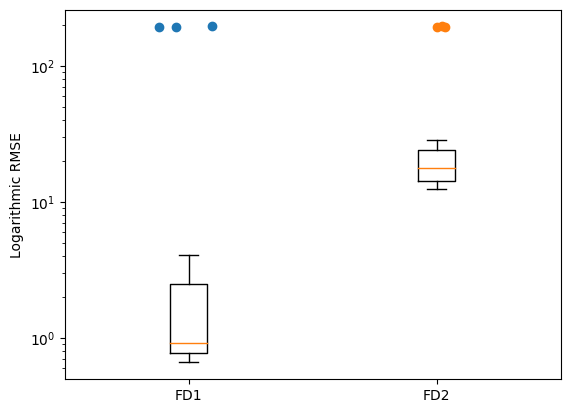

In [38]:
fd1_outliers = fd1_results[fd1_results > 75]
fd1_perf = fd1_results[fd1_results <= 75]
fd2_outliers = fd1_results[fd1_results > 75]
fd2_perf = fd2_results[fd2_results <= 75]

plt.boxplot(fd1_perf, positions=[0])
plt.boxplot(fd2_perf, positions=[1])
plt.scatter(np.random.randn(len(fd1_outliers)) * 0.05, fd1_outliers)
plt.scatter(1 + np.random.randn(len(fd2_outliers)) * 0.05, fd2_outliers)

plt.xticks([0, 1], ["FD1", "FD2"])
plt.yscale("log")
plt.ylabel("Logarithmic RMSE")
plt.show()